In [23]:
#chunk 1

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import confusion_matrix
from optbinning import OptimalBinning
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings('ignore')

In [24]:
#chunk 2

df = pd.read_csv('./credit_score_data.csv')
df.shape

(200000, 26)

In [25]:
#chunk 3

categorical_columns = ['sex', 'education', 'civil_status', 'work_disability', 'main_os']
df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True)
df_encoded.shape

(200000, 28)

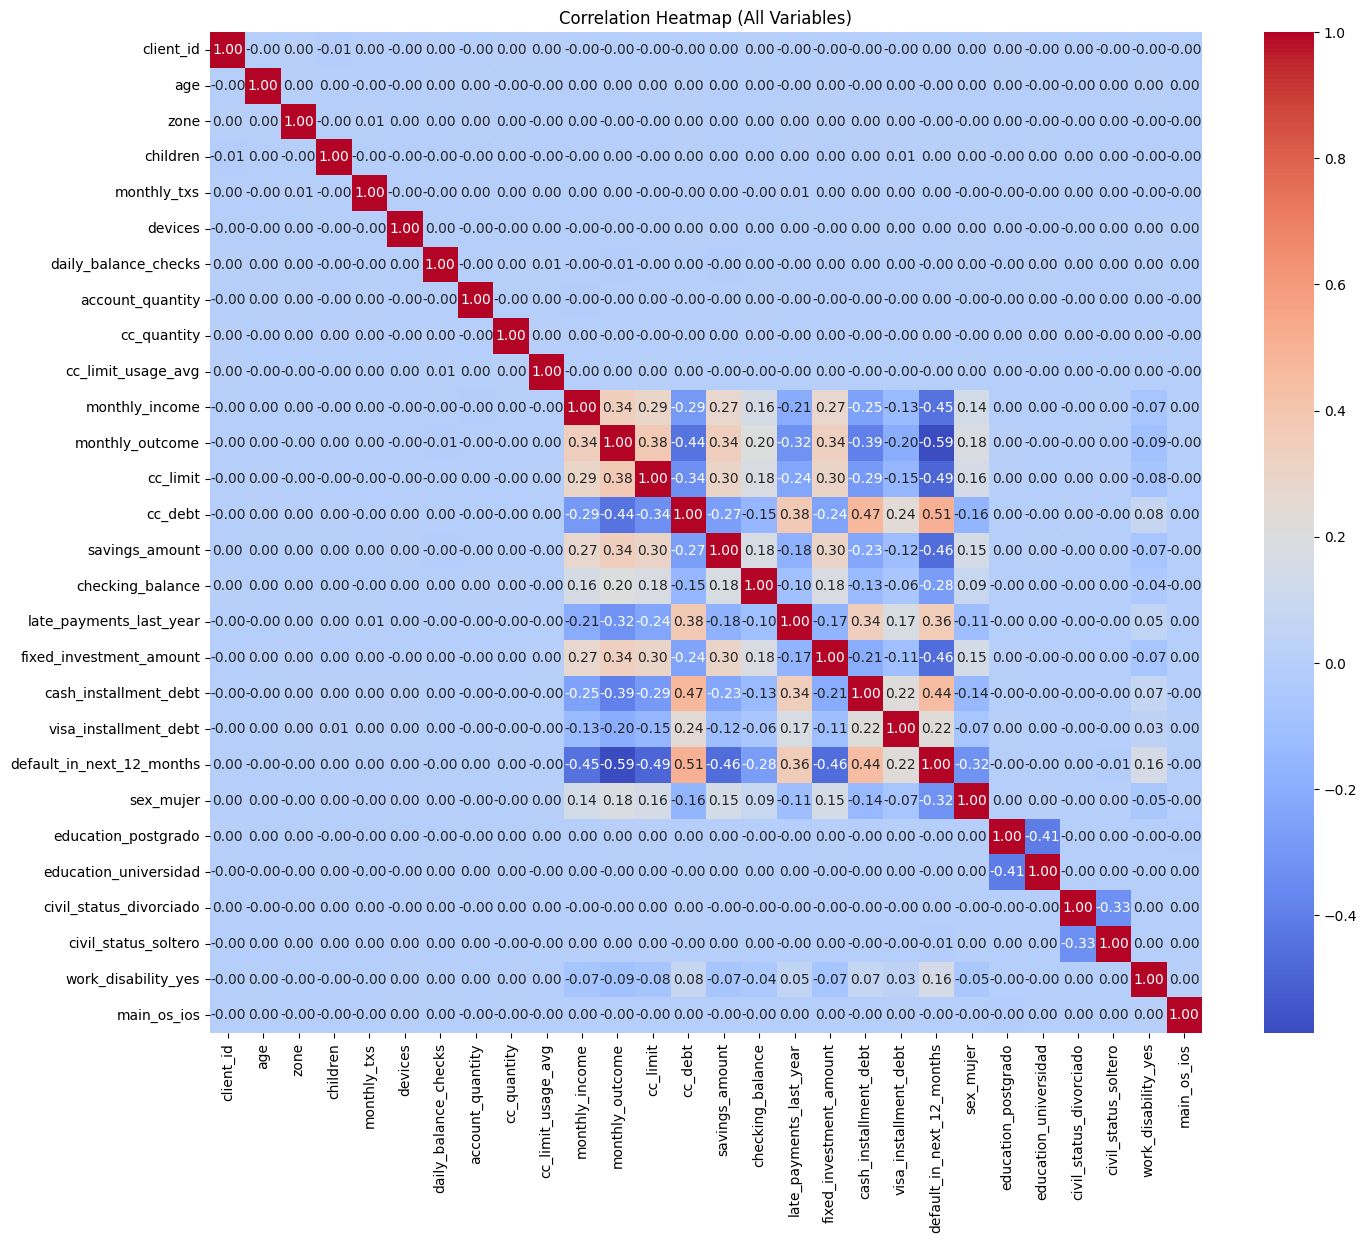

In [26]:
#chunk 4

plt.figure(figsize=(16, 13))
sns.heatmap(df_encoded.corr(),annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap (All Variables)')
plt.show()


In [27]:
#chunk 5
#Método 1: IV
features_iv = [col for col in df_encoded.columns if col not in ['client_id', 'default_in_next_12_months']]
target = 'default_in_next_12_months'
iv_values = {}

for feature in features_iv:
    try:
        optb = OptimalBinning(name=feature, dtype="numerical")
        optb.fit(df_encoded[feature], df_encoded[target])
        binning_table = optb.binning_table
        binning_table.build()
        iv_values[feature] = binning_table.iv
    except Exception:
        continue

iv_df = pd.DataFrame.from_dict(iv_values, orient='index', columns=['IV']).sort_values(by='IV', ascending=False)
pd.set_option('display.float_format', '{:.4f}'.format)
print(iv_df)


                            IV
fixed_investment_amount 3.8251
monthly_outcome         3.3071
savings_amount          2.7090
cc_limit                2.3696
cc_debt                 2.1289
monthly_income          1.9098
cash_installment_debt   1.4407
late_payments_last_year 0.9371
checking_balance        0.7638
sex_mujer               0.7159
visa_installment_debt   0.5554
work_disability_yes     0.1205
age                     0.0003
cc_limit_usage_avg      0.0003
children                0.0002
monthly_txs             0.0002
zone                    0.0002
civil_status_soltero    0.0002
daily_balance_checks    0.0001
cc_quantity             0.0000
account_quantity        0.0000
devices                 0.0000
education_postgrado     0.0000
civil_status_divorciado 0.0000
education_universidad   0.0000
main_os_ios             0.0000


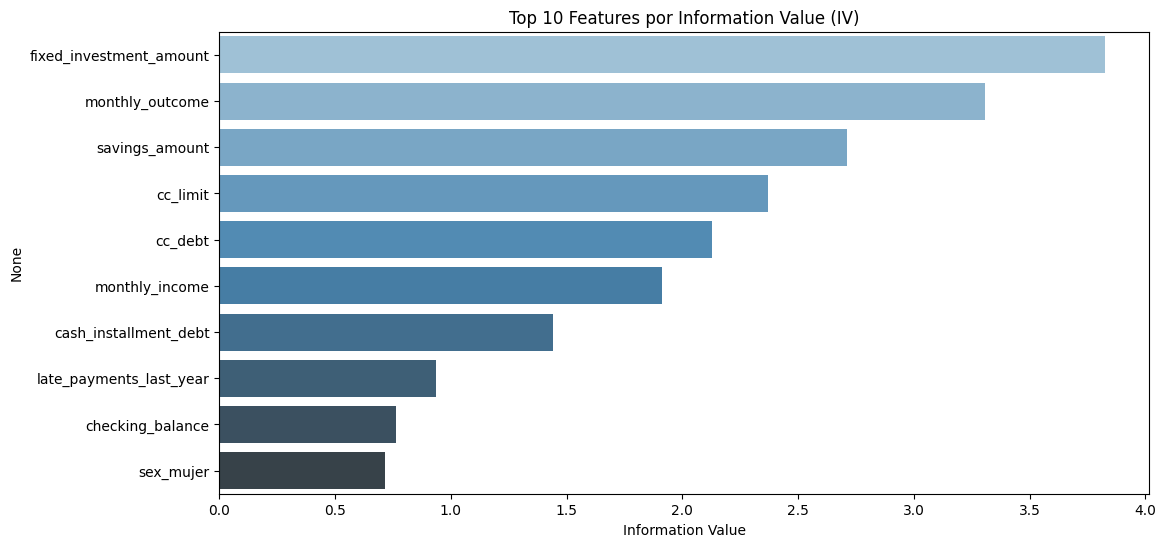

In [37]:
#chunk 6
plt.figure(figsize=(12, 6))
sns.barplot(x=iv_df.IV.head(10), y=iv_df.index[:10], palette='Blues_d')
plt.title('Top 10 Features por Information Value (IV)')
plt.xlabel('Information Value')
plt.show()

In [ ]:
#chunk 7
#Método 2: ABS Coef

X = df_encoded[features_iv]
y = df_encoded[target]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
model = LogisticRegression()
model.fit(X_scaled, y)

# Coefficient importance
coefs = np.abs(model.coef_[0])
coef_df = pd.DataFrame({'Feature': features_iv, 'Abs_Coefficient': coefs})

# Permutation importance
perm_importance = permutation_importance(model, X_scaled, y, n_repeats=30)
coef_df['Permutation_Importance'] = perm_importance.importances_mean

coef_df = coef_df.round(4)

coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)
print (coef_df)


                    Feature  Abs_Coefficient  Permutation_Importance
19                sex_mujer           0.8968                  0.0105
10          monthly_outcome           0.7155                  0.0105
16  fixed_investment_amount           0.6532                  0.0109
13           savings_amount           0.6065                  0.0089
11                 cc_limit           0.5682                  0.0060
12                  cc_debt           0.5029                  0.0003
9            monthly_income           0.5023                  0.0046
17    cash_installment_debt           0.4054                 -0.0005
24      work_disability_yes           0.3133                  0.0017
14         checking_balance           0.3028                  0.0018
15  late_payments_last_year           0.2989                 -0.0004
18    visa_installment_debt           0.1700                 -0.0003
23     civil_status_soltero           0.0301                  0.0000
7               cc_quantity       

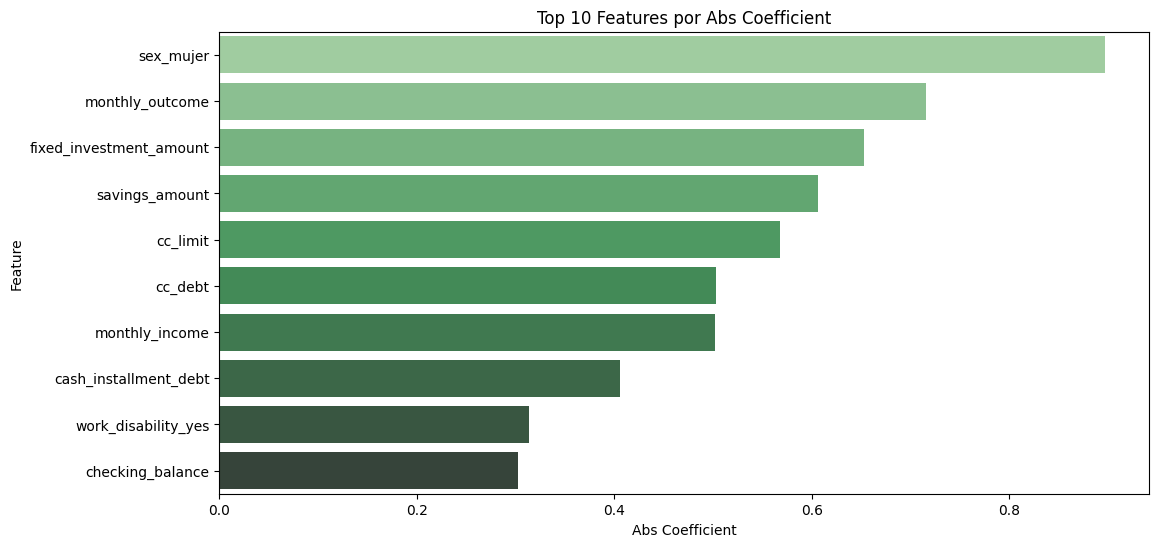

In [36]:
#chunk 8
plt.figure(figsize=(12, 6))
sns.barplot(x=coef_df.Abs_Coefficient.head(10), y=coef_df.Feature.head(10), palette='Greens_d')
plt.title('Top 10 Features por Abs Coefficient')
plt.xlabel('Abs Coefficient')
plt.show()


In [39]:
# Chunk 9
# Método 3  Información mutua (mutual_info_classif)

selector = SelectKBest(score_func=mutual_info_classif, k='all')
selector.fit(X, y)
mi_scores = pd.DataFrame({'Feature': features_iv, 'MI Score': selector.scores_})
mi_scores = mi_scores.sort_values(by='MI Score', ascending=False)
print (mi_scores)

                    Feature  MI Score
16  fixed_investment_amount    0.2672
10          monthly_outcome    0.2419
13           savings_amount    0.1993
11                 cc_limit    0.1759
12                  cc_debt    0.1571
9            monthly_income    0.1419
17    cash_installment_debt    0.1149
15  late_payments_last_year    0.0871
19                sex_mujer    0.0831
14         checking_balance    0.0578
18    visa_installment_debt    0.0467
21    education_universidad    0.0267
23     civil_status_soltero    0.0226
7               cc_quantity    0.0217
25              main_os_ios    0.0127
24      work_disability_yes    0.0104
4                   devices    0.0095
6          account_quantity    0.0086
2                  children    0.0047
5      daily_balance_checks    0.0038
1                      zone    0.0019
3               monthly_txs    0.0016
22  civil_status_divorciado    0.0011
0                       age    0.0010
20      education_postgrado    0.0009
8        cc_

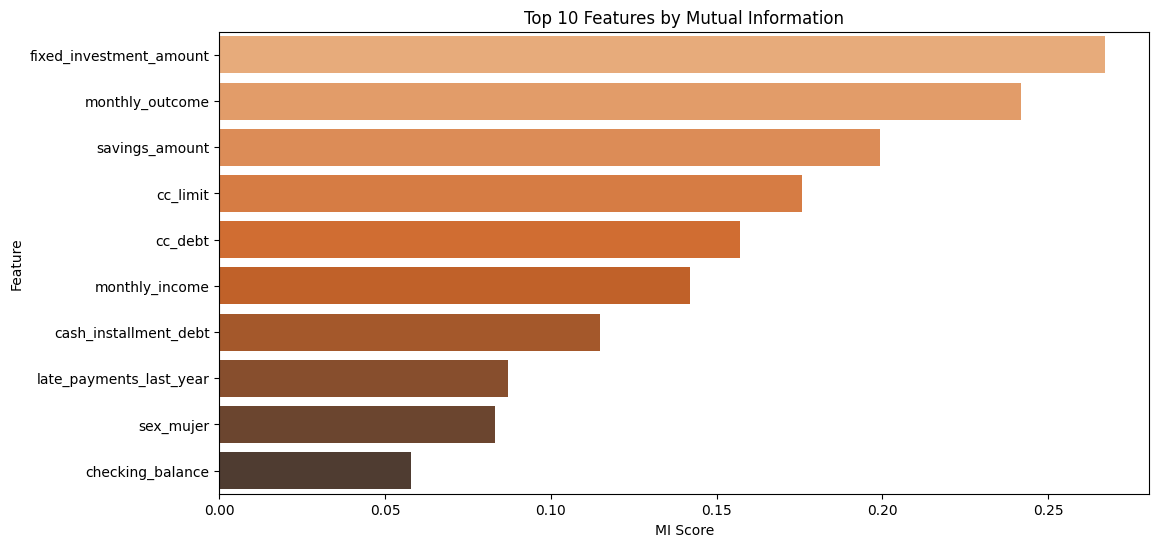

In [40]:
# Chunk 10
plt.figure(figsize=(12, 6))
sns.barplot(x=mi_scores['MI Score'].head(10), y=mi_scores['Feature'].head(10), palette='Oranges_d')
plt.title('Top 10 Features by Mutual Information')
plt.xlabel('MI Score')
plt.show()


In [41]:
# Chunk 11

final_features = ['monthly_income', 'cc_limit_usage_avg', 'cc_limit', 'cc_debt',
                  'checking_balance', 'savings_amount', 'monthly_outcome', 
                  'fixed_investment_amount', 'late_payments_last_year']
X_final = df_encoded[final_features]
y_final = df_encoded['default_in_next_12_months']

Según los tres métodos de evaluación de importancia de variables utilizados —Information Value (IV), Coeficientes absolutos de regresión logística y Información mutua (mutual_info_classif)— se seleccionaron las siguientes 9 features finales por su alta relevancia para predecir el riesgo de default en los próximos 12 meses:

1. monthly_income

2. monthly_outcome

3. cc_limit_usage_avg

4. cc_limit

5. cc_debt

6. savings_amount

7. checking_balance

8. fixed_investment_amount

9. late_payments_last_year

Estas variables mostraron de forma consistente altos valores en al menos dos de los tres métodos aplicados, y representan aspectos clave del comportamiento financiero de los clientes, como ingresos, deudas, ahorros, capacidad de pago.

In [43]:
# Chunk 12: Modelo final con features seleccionadas
X_scaled_final = scaler.fit_transform(X_final)
model_final = LogisticRegression()
model_final.fit(X_scaled_final, y_final)
y_pred = model_final.predict(X_scaled_final)

# Matriz de confusión
cm = confusion_matrix(y_final, y_pred)
print("Matriz de Confusión:")
print(cm)

print()
# KS Statistic
pred_probs = model_final.predict_proba(X_scaled_final)[:,1]
from scipy.stats import ks_2samp
ks = ks_2samp(pred_probs[y_final==0], pred_probs[y_final==1])
print(f'KS Statistic: {ks.statistic:.4f}')

Matriz de Confusión:
[[155489   4511]
 [  8522  31478]]

KS Statistic: 0.7689


En este proyecto se aplicaron tres métodos distintos para evaluar la importancia de las variables del dataset de riesgo crediticio, con el fin de seleccionar las features más relevantes para construir un modelo de predicción de default en los próximos 12 meses.


### Evaluación de Features

#### Heatmap de Correlación
Se visualizó la matriz de correlación entre todas las variables, destacando correlaciones significativas entre:
monthly_income y monthly_outcome: 0.43
cc_limit y cc_debt: 0.60
savings_amount con varias variables financieras

También se observó una correlación moderada entre default_in_next_12_months y variables como late_payments_last_year y monthly_outcome, lo cual ya sugería relevancia.


#### Information Value (IV)
Los valores de IV se calcularon con optbinning, clasificando las variables según su capacidad predictiva. Según la escala estándar:
- IV > 0.5 → Muy fuerte
- 0.3 < IV ≤ 0.5 → Fuerte
- 0.1 < IV ≤ 0.3 → Moderada
- IV ≤ 0.1 → Débil

Las variables más destacadas fueron:

| Variable                 | IV       | Interpretación     |
|--------------------------|----------|---------------------|
| fixed_investment_amount | **3.82** | Muy fuerte          |
| monthly_outcome          | **3.31** | Muy fuerte          |
| savings_amount           | **2.70** | Muy fuerte          |
| cc_limit                 | **2.37** | Muy fuerte          |
| cc_debt                  | **2.12** | Muy fuerte          |


#### Coeficientes Absolutos (Regresión Logística)
Los coeficientes reflejan el impacto que tiene cada variable en la probabilidad de default. Las variables con mayor peso fueron:
- sex_mujer: 0.89
- monthly_outcome: 0.71
- fixed_investment_amount: 0.65
- savings_amount, cc_limit, cc_debt, monthly_income: todos > 0.5



#### Información Mutua (SelectKBest)
Este método evalúa la dependencia no lineal entre cada variable y el target. Los puntajes más altos fueron:
- fixed_investment_amount: 0.267
- monthly_outcome: 0.242
- savings_amount: 0.199
- cc_limit: 0.176
- cc_debt: 0.157


### Features Seleccionadas

Basado en los tres métodos, se seleccionaron las siguientes 9 variables finales por mostrar consistencia en su alto valor predictivo:
- monthly_income
- monthly_outcome
- cc_limit_usage_avg
- cc_limit
- cc_debt
- savings_amount
- checking_balance
- fixed_investment_amount
- late_payments_last_year

### Entrenamiento del Modelo Final

Se entrenó una regresión logística con estas 9 variables estandarizadas. La matriz de confusión fue:

[[155489     4511]

[ 8522     31478]]


Interpretación:
- 155,489 verdaderos negativos (clientes sanos bien clasificados)
- 31,478 verdaderos positivos (riesgos correctamente detectados)
- 8,522 falsos negativos (riesgos no detectados)
- 4,511 falsos positivos (clientes sanos clasificados como riesgo)

### Evaluación del KS (Kolmogorov-Smirnov)

#### KS Statistic: 0.7689

Este valor indica una separación excelente entre las distribuciones de clientes que sí y no caen en default:

KS > 0.4 → Bueno

KS > 0.6 → Muy bueno

KS > 0.75 → Excelente 


Para concluir se puede decir que todos los métodos coincidieron en que las variables relacionadas con ingresos, egresos, deudas, inversiones y morosidad pasada son las más relevantes para predecir el riesgo de default. El modelo final tiene una precisión elevada y una excelente capacidad para diferenciar entre clientes confiables y de alto riesgo, validado tanto por la matriz de confusión como por el KS. Por lo tanto, este análisis es una base sólida para una futura implementación real en procesos de scoring crediticio.


